# INFMDI 721
## Hackathon "données de santé"

Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires ? Est-ce  dans les territoires où la densité est la plus forte que les médecins  pratiquent le moins les dépassement d'honoraires ? Est ce que la densité de certains médecins / praticiens est corrélé à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import xlrd

## Import des données
- df_densite : DENSITÉ DE MÉDECINS par spécialité, modes d'exercice regroupés et zone d'inscription / Source : ASIP-Santé RPPS, traitements Drees; INSEE / Lien : http://www.data.drees.sante.gouv.fr/ReportFolders/reportFolders.aspx?IF_ActivePath=P,490,497,514

- df_honoraires : HONORAIRES TOTAUX DES PROFESSIONNELS DE SANTE PAR DEPARTEMENT EN 2016 / Source: Data.gouv.fr / Lien: https://www.data.gouv.fr/fr/datasets/honoraires-des-professionnels-de-sante-liberaux/

- df_population : Estimation de population par département, sexe et âge quinquennal - Années 1975 à 2018 / Source : INSEE / Lien : https://www.insee.fr/fr/statistiques/1893198

In [2]:
# Dictionnaire des Specialitées
key_specialite = pd.read_excel('KEY.xls', sheet_name="Specialite")
key_specialite = key_specialite.set_index('Specialite_1')['Specialite_2'].to_dict()

# Dictionnaire des Département
key_departement = pd.read_excel('KEY.xls',sheet_name="Departement")
key_departement = key_departement.set_index('Departement_1')['Departement_2'].to_dict()

In [3]:
# Import des données sur les Honoraires
df_nomenclature = pd.read_excel('Honoraires_2016.xls', sheet_name="Nomenclature des PS", header=None, skiprows=3).drop(2, axis=1)
df_nomenclature = df_nomenclature.set_index(1)[0].to_dict()
sheetnames = xlrd.open_workbook(r'Honoraires_2016.xls', on_demand=True).sheet_names()
df_honoraires = {}
for sheet in sheetnames:
    df_honoraires[sheet]=pd.read_excel('Honoraires_2016.xls', sheet_name=sheet)

In [4]:
# Import des données sur les Densités
df_densite = pd.read_excel('Densite_2016.xls', skiprows=4).set_index("SPECIALITE")

In [5]:
# Import des données sur la répartition de la population
df_population = pd.read_excel('Population_2016.xls', skiprows=4, sheet_name="2016").set_index("Departement")

## Construction du DataFrame

In [6]:
# Construit le DataFrame Honoraires/Densité
colnames = ["Specialite", "Departement", "Effectifs", "Densite", "Honoraires_sans_depassement", "Depassement", "Frais_deplacement", "Total"]
df = pd.DataFrame(columns=colnames)
i = 0
for key_s, value_s in key_specialite.items():
    for key_d, value_d in key_departement.items():
        density = df_densite[key_s][key_d]
        specialite = key_s
        departement = value_d
        effectifs = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['EFFECTIFS']
        honoraires = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['HONORAIRES SANS DEPASSEMENT (Euros)']
        depassement = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['DEPASSEMENTS (Euros)']
        deplacement = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['FRAIS DE DEPLACEMENT (Euros)']
        total = df_honoraires[df_nomenclature[value_s]][(df_honoraires[df_nomenclature[value_s]][df_nomenclature[value_s]] == value_s) & (df_honoraires[df_nomenclature[value_s]]['DEPARTEMENT'] == value_d)].iloc[0]['TOTAL DES HONORAIRES (Euros)']
        df.loc[i] = [specialite, departement, effectifs, density, honoraires, depassement, deplacement, total]
        i += 1

In [7]:
# Retraitement des données
df["Specialite"] = df["Specialite"].str.lower()
df = df[df["Depassement"] != 'nc']
df["Ratio"] = df["Depassement"] / (1 + df["Total"])

## Regression Linéaire: 
### Varibale à expliquer: Ratio dépassement d'honoraires sur Total des honoraires
### Variable explicative: Densité de médecins pour 100k habitants

### a) Par Spécialité

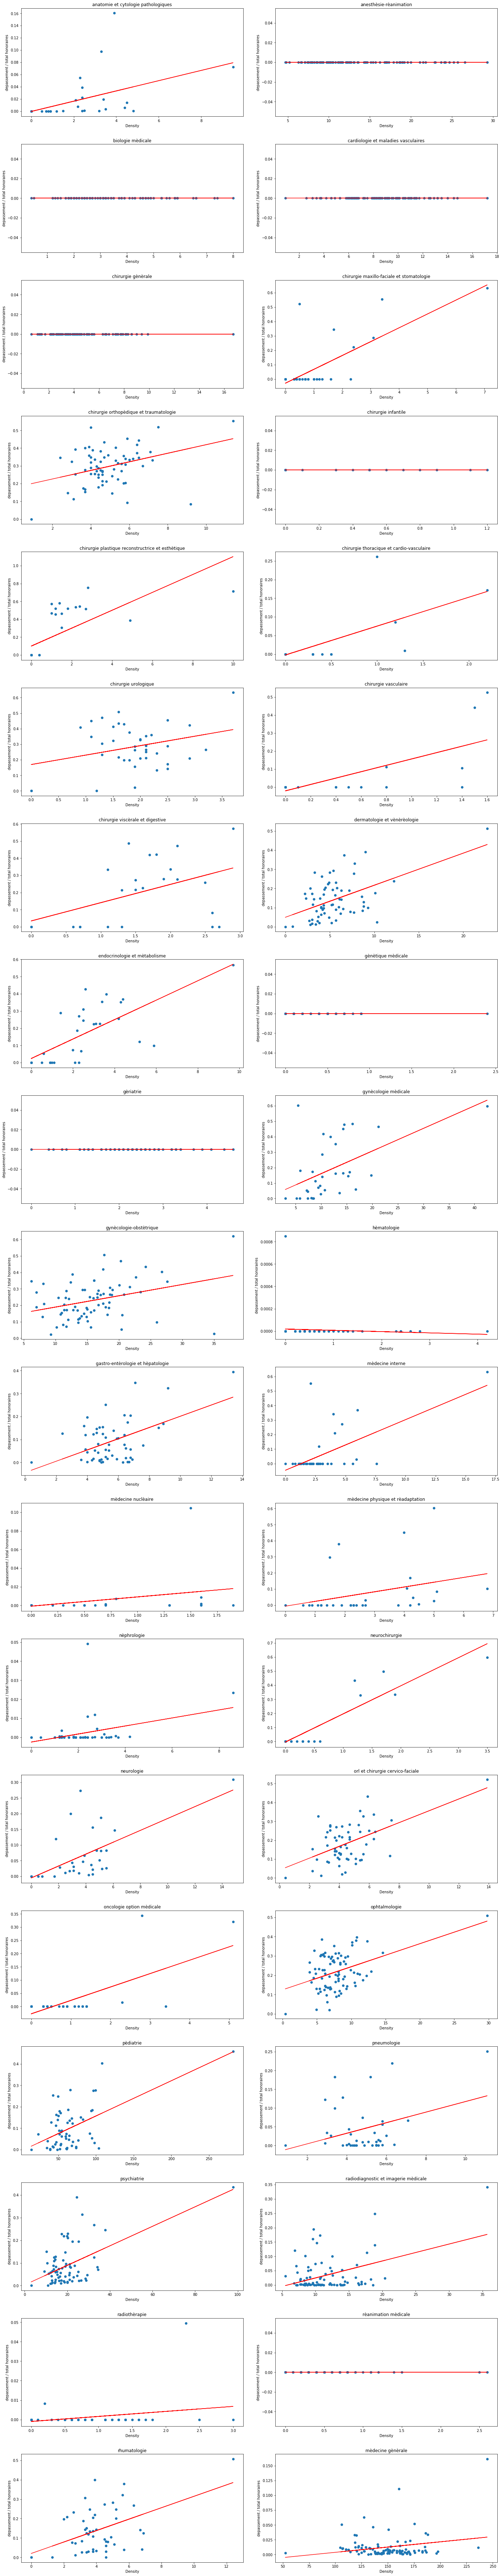

In [16]:
df_specialite = df.set_index(['Specialite', 'Departement'])

specialite_list = list(key_specialite.keys())
specialite_list = [w.lower() for w in specialite_list]

nb_rows = int(np.ceil(len(specialite_list) / 2))
fig, axes = plt.subplots(nrows=nb_rows, ncols=2, figsize=(20, 100))
counter = 0

lr_specialite_result = {}

for i in range(nb_rows):
    for j in range(2):
        ax = axes[i][j]
        if counter < len(specialite_list):
            lr = LinearRegression().fit(df_specialite.loc[specialite_list[counter]][['Densite']], df_specialite.loc[specialite_list[counter]][['Ratio']])
            lr_specialite_result[specialite_list[counter]] = [lr.coef_[0][0],lr.score(df_specialite.loc[specialite_list[counter]][['Densite']],df_specialite.loc[specialite_list[counter]][['Ratio']])]
            pred = lr.predict(df_specialite.loc[specialite_list[counter]][['Densite']])
            ax.plot(df_specialite.loc[specialite_list[counter]]['Densite'],df_specialite.loc[specialite_list[counter]]['Ratio'],'o')
            ax.plot(df_specialite.loc[specialite_list[counter]]['Densite'],pred,c='red')
            ax.set_title(specialite_list[counter])
            ax.set_xlabel("Density")
            ax.set_ylabel("depassement / total honoraires")
        else:
            ax.set_axis_off()
        counter += 1

plt.tight_layout(pad=3, w_pad=3, h_pad=3)
plt.show()

In [17]:
df_lr_specialite_result = pd.DataFrame.from_dict(lr_specialite_result, orient='index', columns=['Coefficient', 'R2'])
df_lr_specialite_result

,Coefficient,R2
anatomie et cytologie pathologiques,0.008399,0.226663
anesthèsie-rèanimation,0.000000,1.000000
biologie mèdicale,0.000000,1.000000
cardiologie et maladies vasculaires,0.000000,1.000000
chirurgie gènèrale,0.000000,1.000000
chirurgie maxillo-faciale et stomatologie,0.096156,0.558452
chirurgie orthopèdique et traumatologie,0.024169,0.125419
chirurgie infantile,0.000000,1.000000
chirurgie plastique reconstructrice et esthètique,0.100164,0.505093
chirurgie thoracique et cardio-vasculaire,0.077546,0.516339


### b) Par Département

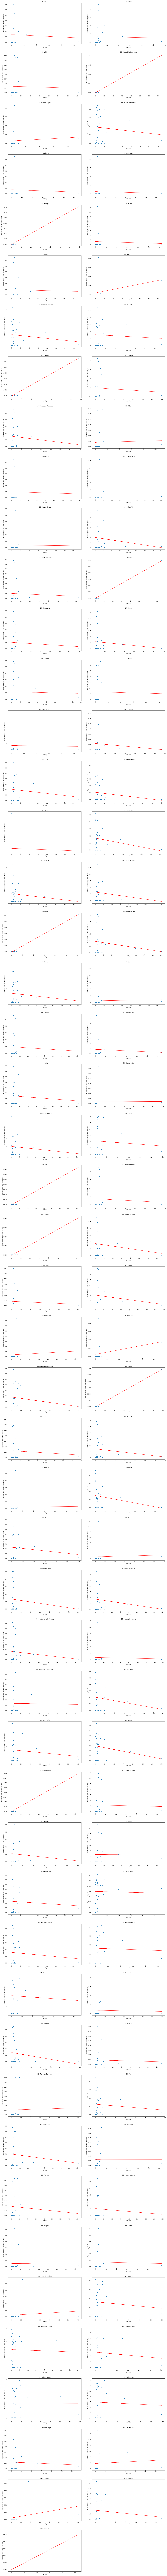

In [18]:
df_departement = df.set_index(['Departement', 'Specialite'])
departement_list = list(key_departement.values())

nb_rows = int(np.ceil(len(departement_list) / 2))
fig, axes = plt.subplots(nrows=nb_rows, ncols=2, figsize=(20, 300))
counter = 0

lr_departement_result = {}

for i in range(nb_rows):
    for j in range(2):
        ax = axes[i][j]
        if counter < len(departement_list):
            # Regression lineaire
            lr = LinearRegression().fit(df_departement.loc[departement_list[counter]][['Densite']], df_departement.loc[departement_list[counter]][['Ratio']])
            lr_departement_result[departement_list[counter]] = [lr.coef_[0][0],lr.score(df_departement.loc[departement_list[counter]][['Densite']],df_departement.loc[departement_list[counter]][['Ratio']])]
            
            # Prediction 
            pred = lr.predict(df_departement.loc[departement_list[counter]][['Densite']])
            # Graphique nuage de point & regression 
            ax.plot(df_departement.loc[departement_list[counter]]['Densite'],df_departement.loc[departement_list[counter]]['Ratio'],'o')
            ax.plot(df_departement.loc[departement_list[counter]]['Densite'],pred, c='red')
            ax.set_title(departement_list[counter])
            ax.set_xlabel("density")
            ax.set_ylabel("depassement / total honoraires")
        else:
            ax.set_axis_off()
        counter += 1
plt.tight_layout(pad=3, w_pad=3, h_pad=3)
plt.show()

In [19]:
df_lr_departement_result = pd.DataFrame.from_dict(lr_departement_result, orient='index', columns=['Coefficient', 'R2'])
df_lr_departement_result

,Coefficient,R2
01- Ain,-2.836343e-04,3.574995e-03
02- Aisne,-7.017741e-05,7.497673e-04
03- Allier,-7.519490e-05,1.072317e-03
04- Alpes-Hte-Provence,2.193679e-05,9.957932e-01
05- Hautes-Alpes,3.603856e-05,9.169572e-03
06- Alpes-Maritimes,-4.972282e-04,1.228603e-02
07- Ardèche,-1.674075e-04,1.868686e-03
08- Ardennes,-7.376037e-05,1.957961e-03
09- Ariège,2.086514e-06,9.949239e-01
10- Aube,-1.730090e-04,2.609602e-03


## Correlation entre 
### la Répartition des differentes classes d'âge de la population
### la Densité de médecins par habitant

### a) Densité Pédiatrie et pourcentage de la population <4ans

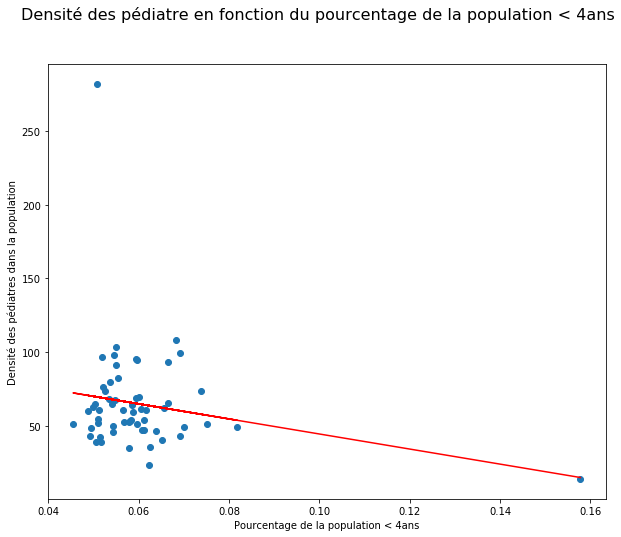

In [14]:
index_departement_pediatrie = list(df_specialite.loc["pèdiatrie"].index)
df_pediatrie = pd.concat([df_specialite.loc["pèdiatrie"], df_population.loc[index_departement_pediatrie]], axis=1)
df_pediatrie["Ratio 0 à 4 ans"] = df_pediatrie['0 à 4 ans'] / df_pediatrie['Total Population']

# Regression lineaire
lr = LinearRegression().fit(df_pediatrie[['Ratio 0 à 4 ans']],df_pediatrie['Densite'])

# Prediction 
pred = lr.predict(df_pediatrie[['Ratio 0 à 4 ans']])

# Graphique nuage de point & regression 
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Densité des pédiatre en fonction du pourcentage de la population < 4ans', fontsize = 16)
plt.plot(df_pediatrie['Ratio 0 à 4 ans'],df_pediatrie['Densite'],'o')
plt.plot(df_pediatrie['Ratio 0 à 4 ans'],pred,c='red')
plt.xlabel('Pourcentage de la population < 4ans')
plt.ylabel('Densité des pédiatres dans la population')
plt.show()